In [7]:
import sys
sys.path.append("..")

from tree_parser import file_contents, meta_math_database

from my_utils import print_proof_props_graph, get_proof_steps, print_ident_proof, print_proof_linear_steps
from my_utils import get_proof_steps_graph, print_proof_steps_graph


from expanding import construct_proof, expand_proof_step_ps#, replace_expanded_step

from collections import defaultdict

In [ ]:
%%time

text = file_contents("../set.mm")
database = meta_math_database(text,n=3500)

In [21]:
def expand(self):
    if self.is_hyp:
        return self#.get_root_step()

    exp_self = expand_proof_step_ps(self)

    if exp_self == None: #No more expansions are possible
        return self#.get_root_step()

    exp_self._expanded_from = self

    for s in exp_self.get_steps_df():
        #Not so sure whether this is correct or not
        s._expanded_from = self
        s.depth = self.depth + 1
        s.statement_depth = self.statement_depth + 1

    #The step which calls the expand method should not have 
    #its statement depth increase since it is the same statement as the original step
    #so lets roll it back.
    exp_self.statement_depth = self.statement_depth

    #Replace the expanded step in the proof it belongs to
    #This means replace connections from the previous nodes with the newest nodes
    exp_self_in_proof = replace_expanded_step(self, exp_self)
    return exp_self_in_proof

In [22]:
def replace_expanded_step(step, expanded_step, ):
    # Replace root node
    if step.output != None:
        expanded_step.output = step.output
        step_output_index = step.output.inputs.index(step)
        step.output.inputs[step_output_index] = expanded_step
        
    # Replace hyps
    ## Get hyps out nodes (this is necessary because hyp nodes must be replaced and not connected)
    #expanded_step_hyps = [h.output for h in expanded_step.get_hyps()]
    expanded_step_hyps = expanded_step.get_hyps()
    
    #Since there may be use of the same declared hypothesis twice (like in bitri proof)
    #We need to handle this assigning hyps to a dict
    exp_hyps_dict = defaultdict(list)
    
    #We have to take the list of hypothesis this way so we can make sure the 
    #proper order is maintained with the original step inputs order.
    #Using the order returned by the depth first search in expanded_step.get_hyps() 
    #may return problematic orders like in the case of mp2 proposition in the impbii proof
    #This will also work as a sanity checker since we are getting hypothesis labels from diferent
    #places that are expected to match.
    exp_hyps_list = [h.label for h in step._step.prop.hyps if h.type == "e"]
    
    for exp_hyp in expanded_step_hyps:
        exp_hyps_dict[exp_hyp.label].append(exp_hyp)
    
    assert len(step.inputs) == len(exp_hyps_list), f"{len(step.inputs)} {step.inputs} {len(exp_hyps_list)} {exp_hyps_list} {len(exp_hyps_dict)} {exp_hyps_dict}"
     
    for step_input, exp_hyp_label in zip(step.inputs, exp_hyps_list):
        for exp_hyp in exp_hyps_dict[exp_hyp_label]:
            #We have to do this to copy branches where the hypothesis are used twice
            #This will increase the size of the tree however will prevent node crossing
            #while visualizing them, which will help us debug, which is the main goal of this project.
            step_input_cp = step_input.copy()
            step_input_cp.output = exp_hyp.output #(this is necessary because hyp nodes must be replaced and not connected)
            exp_hyp_index = exp_hyp.output.inputs.index(exp_hyp)
            exp_hyp.output.inputs[exp_hyp_index] = step_input_cp
        break
        
    #Return new proof
    #Maybe it is a good idea to perform a deepcopy of every step
    return expanded_step#.get_root_step() 


dfss2


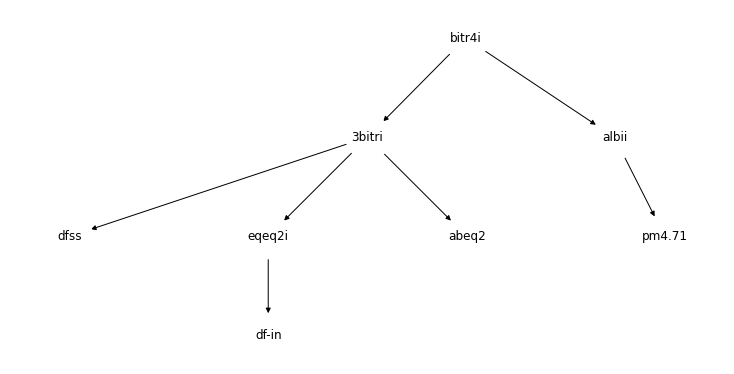

 <PStep:bitr4i ⊢ ( A ⊆ B ↔ ∀ x ( x ∈ A → x ∈ B ) )>
 |  <PStep:3bitri ⊢ ( A ⊆ B ↔ ∀ x ( x ∈ A ↔ ( x ∈ A ∧ x ∈ B ) ) )>
 |  |  <PStep:dfss ⊢ ( A ⊆ B ↔ A = ( A ∩ B ) )>
 |  |  <PStep:eqeq2i ⊢ ( A = ( A ∩ B ) ↔ A = { x | ( x ∈ A ∧ x ∈ B ) } )>
 |  |  |  <PStep:df-in ⊢ ( A ∩ B ) = { x | ( x ∈ A ∧ x ∈ B ) }>
 |  |  <PStep:abeq2 ⊢ ( A = { x | ( x ∈ A ∧ x ∈ B ) } ↔ ∀ x ( x ∈ A ↔ ( x ∈ A ∧ x ∈ B ) ) )>
 |  <PStep:albii ⊢ ( ∀ x ( x ∈ A → x ∈ B ) ↔ ∀ x ( x ∈ A ↔ ( x ∈ A ∧ x ∈ B ) ) )>
 |  |  <PStep:pm4.71 ⊢ ( ( x ∈ A → x ∈ B ) ↔ ( x ∈ A ↔ ( x ∈ A ∧ x ∈ B ) ) )>


In [24]:
prop = database.propositions["dfss2"]
#prop = database.propositions_list[-1]
print(prop.label)
prop_proof = construct_proof(prop)
prop_proof.print_graph()
prop_proof.print_linear()

In [ ]:
prop = database.propositions["dfss2"]
#prop = database.propositions_list[-1]
print(prop.label)
prop_proof = construct_proof(prop)
prop_proof = expand(prop_proof).get_root_step()
prop_proof.print_graph()
prop_proof.print_linear()

In [ ]:
create method to replace nodes partially based on specified hypothesis

aumentar o numero de conexoes de um nó significa perder informaçao da arvore de prova, prejudicando a compreenssão. Precisamos encodar isso de alguma forma.